# 3_EDA: Shipping Cost Predictor

In [1]:
# Imports
import os
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from io import StringIO
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Load variables from .env file, ignoring lines without '='
def load_env_variables(env_file='../.env'):
    # Get the current working directory
    current_dir = os.getcwd()
    env_path = os.path.join(current_dir, '..', env_file)
    
    print(f"Looking for .env file at: {env_path}")  # Debugging output

    if not os.path.exists(env_path):
        print(f".env file does not exist at: {env_path}")
        return

    with open(env_path, 'r') as file:
        for line in file:
            # Skip lines without an equals sign or comments
            if '=' in line and not line.strip().startswith('#'):
                key, value = line.strip().split('=', 1)
                os.environ[key] = value
                print(f"Loaded {key}={value}")  # Debugging output

# Load environment variables
load_env_variables()

Looking for .env file at: c:\repos\ai-logistics\notebooks\ShipCostPredictor\..\../.env
Loaded BUCKET_NAME_INBOUND=logimo-inbound
Loaded BUCKET_NAME_ALIGNED=logimo-aligned
Loaded BUCKET_NAME_OUTBOUND=logimo-outbound
Loaded PREFIX_KEY=ship_cost_predictor


In [4]:
# Create an S3 client
s3 = boto3.client('s3')

# Specify the bucket name and prefix (folder path)
bucket_name = os.getenv('BUCKET_NAME_ALIGNED')
prefix = os.getenv('PREFIX_KEY')

# Fetch the content of the cleaned CSV file from S3
obj = s3.get_object(Bucket=bucket_name, 
                    Key=f'{prefix}/Sample_Data_Product_Cleaned.csv')
# Read the content of the CSV file
csv_content = obj['Body'].read().decode('utf-8')

# Use pandas to read the CSV content into a DataFrame
supply_chain_df_cleaned = pd.read_csv(StringIO(csv_content))

---

### Basic data exploration

In [5]:
# Data glance
supply_chain_df_cleaned.head()

product_type        sku  estimated_price  availability  \
0    cosmetics  062000005           4350.0          98.0   
1    cosmetics  062000004          31840.0          11.0   
2     haircare  062000002          78270.0          10.0   
3     haircare  062000003          51045.0          15.0   
4    cosmetics  062000007          22790.0          17.0   

   number_of_products_sold  revenue_generated customer_demographics  \
0                    216.0            5513.64               Unknown   
1                    407.0            1638.02               Unknown   
2                    399.0               0.00                  Male   
3                    923.0            9417.67            Non-binary   
4                    715.0            8656.12            Non-binary   

   stock_levels  lead_times  order_quantities  ...  production_volumes  \
0          28.0         5.0              16.0  ...               406.0   
1          41.0         7.0              59.0  ...               599.0   
2          66.0        26.0              81.0  ...               721.0   
3          25.0        26.0              50.5  ...               547.0   
4          58.0        24.0              79.0  ...               168.0   

  manufacturing_lead_time  manufacturing_costs inspection_results  \
0                     9.0                98.49               Fail   
1                    15.0                67.15               Fail   
2                    28.0                49.86            Unknown   
3                    12.0                54.20               Fail   
4                    21.0                71.42            Pending   

  defect_rates  transportation_modes   routes    costs  demurrage  \
0         3.27                  Rail  Route_A  329.950        0.0   
1         0.52                  Rail  Route_C  555.645  1365082.0   
2         1.27                  Road  Route_A  996.280        0.0   
3         2.50                   Sea  Route_C  817.380        0.0   
4         3.35                  Rail  Route_B  407.650        0.0   

   demurrage_bin  
0          False  
1           True  
2          False  
3          False  
4          False  

[5 rows x 25 columns]

In [6]:
# Dataset info
supply_chain_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9170 entries, 0 to 9169
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_type             9170 non-null   object 
 1   sku                      9170 non-null   object 
 2   estimated_price          9170 non-null   float64
 3   availability             9170 non-null   float64
 4   number_of_products_sold  9170 non-null   float64
 5   revenue_generated        9170 non-null   float64
 6   customer_demographics    9170 non-null   object 
 7   stock_levels             9170 non-null   float64
 8   lead_times               9170 non-null   float64
 9   order_quantities         9170 non-null   float64
 10  shipping_times           9170 non-null   float64
 11  shipping_carriers        9170 non-null   object 
 12  shipping_costs           9170 non-null   float64
 13  supplier_name            9170 non-null   object 
 14  location                

---

### Dataset description

In [7]:
# Dataset info
supply_chain_df_cleaned.describe()

estimated_price  availability  number_of_products_sold  \
count      9170.000000   9170.000000              9170.000000   
mean      50910.837514     49.872846               502.432497   
std       27572.430764     27.433827               275.381313   
min        1010.000000      1.000000                 1.000000   
25%       28212.500000     27.000000               277.000000   
50%       51045.000000     49.000000               505.000000   
75%       74240.000000     73.000000               728.000000   
max       99990.000000     99.000000               999.000000   

       revenue_generated  stock_levels   lead_times  order_quantities  \
count        9170.000000   9170.000000  9170.000000       9170.000000   
mean         5119.475501     50.154635    14.700872         50.197874   
std          2879.363224     27.821614     8.041001         27.794887   
min             0.000000      1.000000     1.000000          1.000000   
25%          2767.517500     27.000000     8.000000         27.000000   
50%          5160.705000     50.000000    15.000000         50.500000   
75%          7584.602500     74.000000    21.000000         74.000000   
max          9999.550000     99.000000    29.000000         99.000000   

       shipping_times  shipping_costs  production_volumes  \
count     9170.000000     9170.000000         9170.000000   
mean         4.993784      502.108724          549.154635   
std          2.468178      292.278791          251.737822   
min          1.000000        0.000000          100.000000   
25%          3.000000      265.000000          340.000000   
50%          5.000000      506.000000          547.000000   
75%          7.000000      754.000000          762.000000   
max          9.000000     1000.000000          999.000000   

       manufacturing_lead_time  manufacturing_costs  defect_rates  \
count              9170.000000          9170.000000   9170.000000   
mean                 14.932061            51.081433      2.506506   
std                   8.054704            28.580463      1.394080   
min                   1.000000             0.000000      0.000000   
25%                   8.000000            27.430000      1.340000   
50%                  15.000000            51.310000      2.500000   
75%                  22.000000            75.507500      3.670000   
max                  29.000000            99.990000      5.000000   

             costs     demurrage  
count  9170.000000  9.170000e+03  
mean    550.453944  5.137079e+05  
std     250.896988  7.748318e+05  
min     100.160000  0.000000e+00  
25%     338.222500  0.000000e+00  
50%     555.645000  0.000000e+00  
75%     759.060000  1.013754e+06  
max     999.630000  2.499613e+06

| **Variable Name**          | **Description**                                    | **Type of Data** |
|----------------------------|----------------------------------------------------|------------------|
| Product type               | Type of product                                    | Object           |
| SKU                        | Stock Keeping Unit                                 | Object           |
| Estimated Price            | Price of the product                               | Float            |
| Availability               | Availability status of the product                 | Float            |
| Number of products sold    | Number of products sold                            | Float            |
| Revenue generated          | Total revenue generated                            | Float            |
| Customer demographics      | Demographic details of the customers               | Object           |
| Stock levels               | Current stock levels                               | Float            |
| Lead times                 | Time taken from order to delivery                  | Float            |
| Order quantities           | Quantities ordered                                 | Float            |
| Shipping times             | Time taken for shipping                            | Float            |
| Shipping carriers          | Carriers used for shipping                         | Object           |
| Shipping costs             | Cost incurred for shipping                         | Float            |
| Supplier name              | Name of the supplier                               | Object           |
| Location                   | Location of the supplier                           | Object           |
| Lead time                  | Time taken by supplier to fulfill orders           | Float            |
| Production volumes         | Volume of products produced                        | Float            |
| Manufacturing lead time    | Time taken for manufacturing                       | Float            |
| Manufacturing costs        | Costs involved in manufacturing                    | Float            |
| Inspection results         | Results from product inspections                   | Object           |
| Defect rates               | Rates of defects found in products                 | Float            |
| Transportation modes       | Modes of transportation used                       | Object           |
| Routes                     | Routes used for transportation                     | Object           |
| Costs                      | Overall costs                                      | Float            |
| Demurrage                  | Cost incurred when sku faces demurrage             | Float            |


In [8]:
# Dataframe for variable analysis
supply_chain_eda_df = supply_chain_df_cleaned.copy()

---

### Univariate Analysis

In the following section, we will do an analysis per each variable to analyze their distribution, values and other statistical data we can obtain by this analysis.

**Numerical columns** : 

[

    'Estimated Price',
    'Availability',
    'Number of products sold',
    'Revenue generated',
    'Stock levels',
    'Lead times',
    'Order quantities',
    'Shipping times',
    'Shipping costs',
    'Lead time',
    'Production volumes',
    'Manufacturing lead time',
    'Manufacturing costs',
    'Defect rates',
    'Costs',
    'Demurrage'
]

---

In [9]:
demurrage_series = supply_chain_eda_df['demurrage']
filtered_demurrage = demurrage_series.loc[demurrage_series != 0]

In [10]:
filtered_demurrage.describe()

count    3.371000e+03
mean     1.397420e+06
std      6.310082e+05
min      3.000420e+05
25%      8.634105e+05
50%      1.402492e+06
75%      1.935878e+06
max      2.499613e+06
Name: demurrage, dtype: float64

In [11]:
print(f'Number of unique values: {len(supply_chain_eda_df["demurrage"].unique())}')
print(supply_chain_eda_df["demurrage"].unique())

Number of unique values: 3370
[      0. 1365082. 1308003. ... 2094811.  741579.  960097.]


In [12]:
# Setting style for plots
sns.set_theme(style="whitegrid")

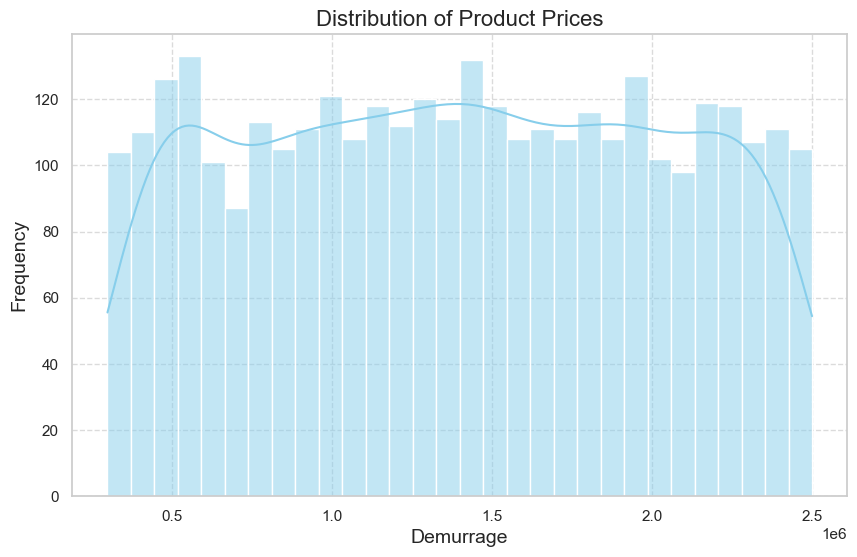

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_demurrage, bins=30, kde=True, color='skyblue')

plt.title('Distribution of Product Prices', fontsize=16)
plt.xlabel('Demurrage', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### Interpretation:

The dataset has a fairly wide range, from 305,736 to 2,499,548, indicating significant variability.
The median (1,408,837) is slightly higher than the mean (1,390,123), suggesting a slightly right-skewed distribution.
The interquartile range (75% - 25%) is 1,068,360, highlighting the spread of the middle 50% of the data.
With a substantial standard deviation, the data points are quite spread out around the mean, indicating diverse values.

---

`Estimated Price`

In [14]:
supply_chain_eda_df['estimated_price'].describe()

count     9170.000000
mean     50910.837514
std      27572.430764
min       1010.000000
25%      28212.500000
50%      51045.000000
75%      74240.000000
max      99990.000000
Name: estimated_price, dtype: float64

- **Mean (Average Price):** The average price is approximately 50.97 units, indicating that products are moderately priced around this central value.
- **Standard Deviation (Variability):** The standard deviation is 28.35 units, showing significant variability in product prices.
- **Minimum Price:** The lowest price is 1.01 units, suggesting the presence of budget-friendly options within the product range.
- **25th Percentile (Q1):** 25% of products are priced at 26.04 units or less, highlighting that a significant portion of products are relatively low-priced.
- **Median (50th Percentile):** The median price is 51.37 units, meaning half the products are priced below and half above this value, indicating a relatively symmetric price distribution.
- **75th Percentile (Q3):** 75% of products are priced at 75.40 units or less, showing that most products fall below this price, with only a quarter being more expensive.

In [15]:
print(f'Number of unique values: {len(supply_chain_eda_df["estimated_price"].unique())}')
print(supply_chain_eda_df["estimated_price"].unique())

Number of unique values: 5798
[ 4350. 31840. 78270. ... 87360. 89580. 27120.]


In [16]:
# Setting style for plots
sns.set_theme(style="whitegrid")

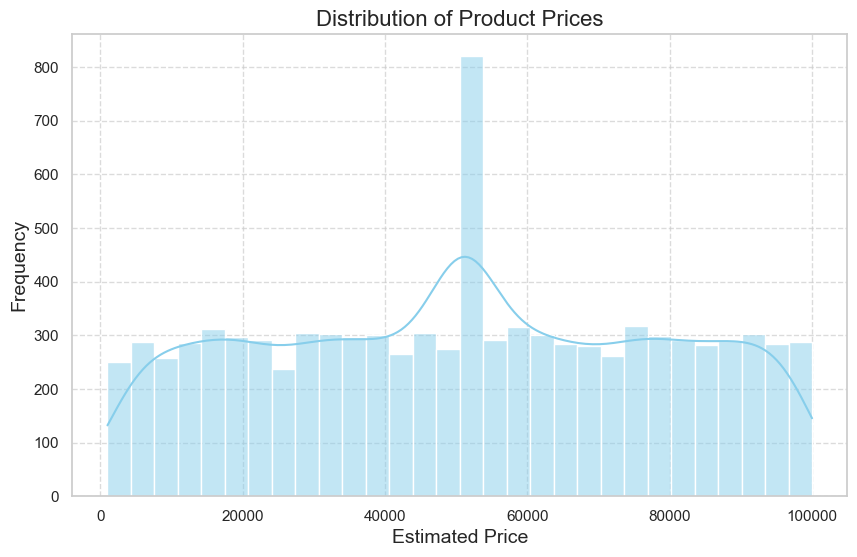

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['estimated_price'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Product Prices', fontsize=16)
plt.xlabel('Estimated Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

- The distribution of product prices is bimodal, with peaks around 10K-20K dollars and 50K-60K dollars.
- Prices significantly taper off after 60K dollars, suggesting fewer higher-priced products.
- The range between 20K and 45K dollars shows a noticeable dip in product frequency.
- A slight uptick in frequency occurs near the 100K dollar mark.
- Most products are priced under 60K dollars, highlighting a concentration of more affordable options in the dataset.

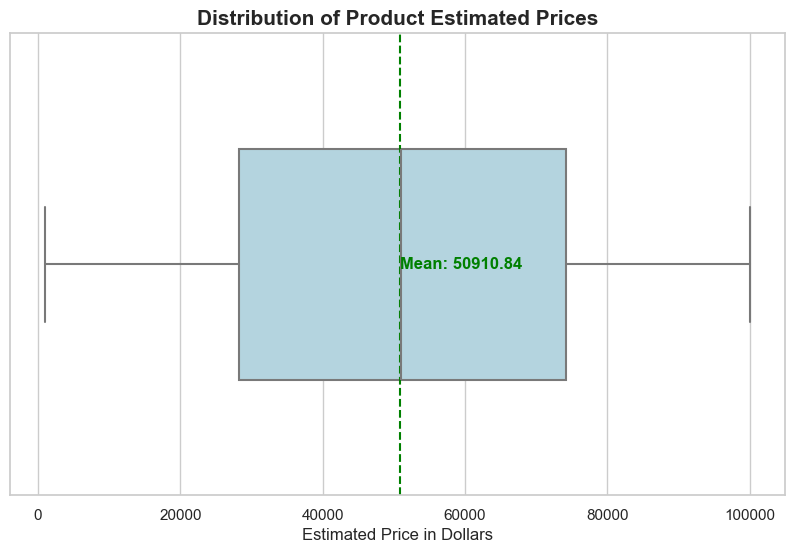

In [18]:
plt.figure(figsize=(10, 6))  
boxplot = sns.boxplot(x=supply_chain_eda_df['estimated_price'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Product Estimated Prices', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Estimated Price in Dollars', fontsize=12)
boxplot.set_ylabel('')  

mean_price = supply_chain_eda_df['estimated_price'].mean()
plt.axvline(mean_price, color='green', linestyle='--') 
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

# Show the plot
plt.show()

- The mean price of the products is approximately 50.97K dollars.
- Prices are symmetrically distributed around the mean.
- Prices range from near 0 to almost 100K dollars.
- The middle 50% of prices (Interquartile Range) spans from about 25K to 75K dollars.
- There are no outliers in the data.
- The lowest prices are close to 0 dollars, and the highest prices approach 100K dollars.

---

`availability`

In [19]:
supply_chain_eda_df['availability'].describe()

count    9170.000000
mean       49.872846
std        27.433827
min         1.000000
25%        27.000000
50%        49.000000
75%        73.000000
max        99.000000
Name: availability, dtype: float64

- The average availability is approximately 50.64 units.
- Availability varies widely, with a standard deviation of 28.57 units.
- The minimum availability recorded is 1 unit.
- 25% of the data points have availability less than or equal to 26 units.
- The median availability is 51 units, indicating that half of the products have availability less than or equal to this value.
- 75% of the data points have availability less than or equal to 75 units.
- The maximum availability recorded is 99 units.

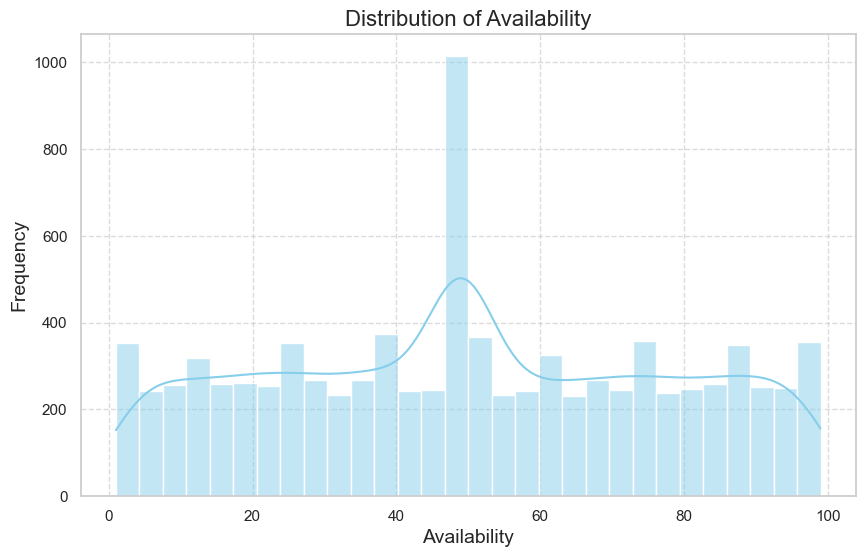

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['availability'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Availability', fontsize=16)
plt.xlabel('Availability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

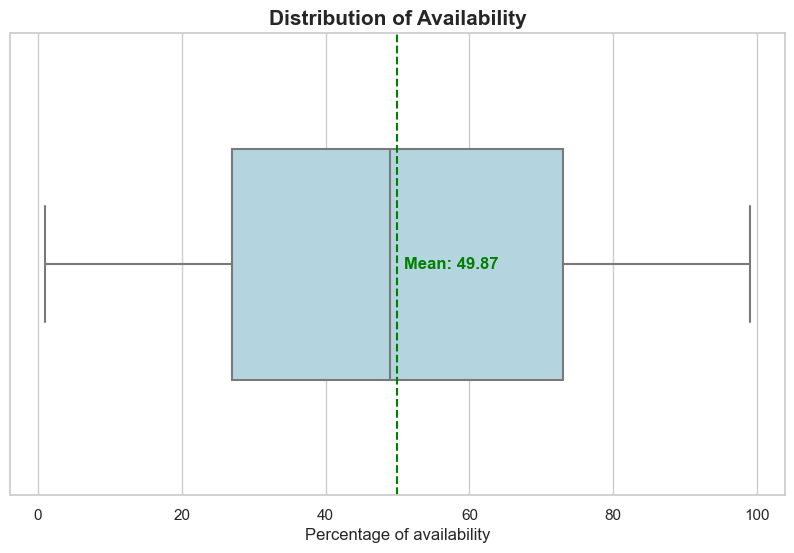

In [21]:
plt.figure(figsize=(10, 6))  
boxplot = sns.boxplot(x=supply_chain_eda_df['availability'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Availability', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Percentage of availability', fontsize=12)
boxplot.set_ylabel('')  

mean_price = supply_chain_eda_df['availability'].mean()
plt.axvline(mean_price, color='green', linestyle='--') 
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Number of products sold`

In [22]:
supply_chain_eda_df['number_of_products_sold'].describe()

count    9170.000000
mean      502.432497
std       275.381313
min         1.000000
25%       277.000000
50%       505.000000
75%       728.000000
max       999.000000
Name: number_of_products_sold, dtype: float64

- The average number of products sold is approximately 508.30 units.
- There is high variability in the number of products sold, with a standard deviation of about 285.99 units.
- The minimum number of products sold is 1 unit.
- 25% of the products have sold 263 units or fewer.
- The median number of products sold is 516 units, meaning half of the products sold fewer than this number.
- 75% of the products have sold 756 units or fewer.
- The maximum number of products sold is 999 units.

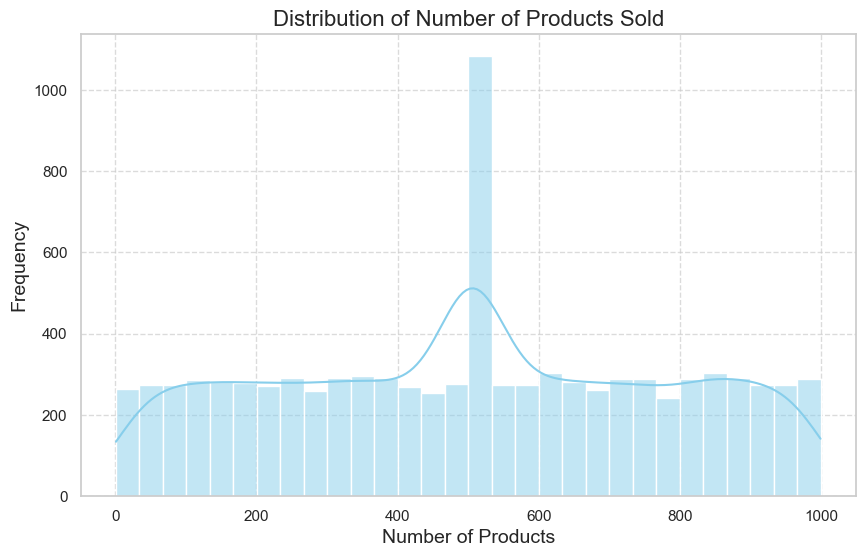

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['number_of_products_sold'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Number of Products Sold', fontsize=16)
plt.xlabel('Number of Products', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

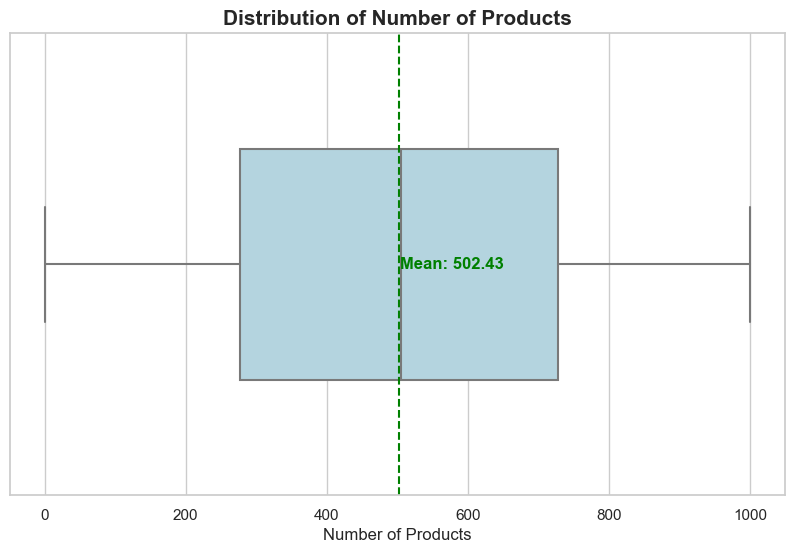

In [24]:
plt.figure(figsize=(10, 6))  
boxplot = sns.boxplot(x=supply_chain_eda_df['number_of_products_sold'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Number of Products', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Number of Products', fontsize=12)
boxplot.set_ylabel('')  

mean_price = supply_chain_eda_df['number_of_products_sold'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Revenue generated`

In [25]:
supply_chain_eda_df['revenue_generated'].describe()

count    9170.000000
mean     5119.475501
std      2879.363224
min         0.000000
25%      2767.517500
50%      5160.705000
75%      7584.602500
max      9999.550000
Name: revenue_generated, dtype: float64

- The average revenue generated is approximately 5594.91 dollars.
- There is substantial variability in revenue, with a standard deviation of about 2569.75 dollars.
- The minimum revenue generated is 1016.19 dollars.
- 25% of the products generate revenue of 3403.43 dollars or less.
- The median revenue generated is 5640.64 dollars, indicating half of the products generate less than this amount.
- 75% of the products generate revenue of 7758.96 dollars or less.
- The maximum revenue generated is 9994.80 dollars.

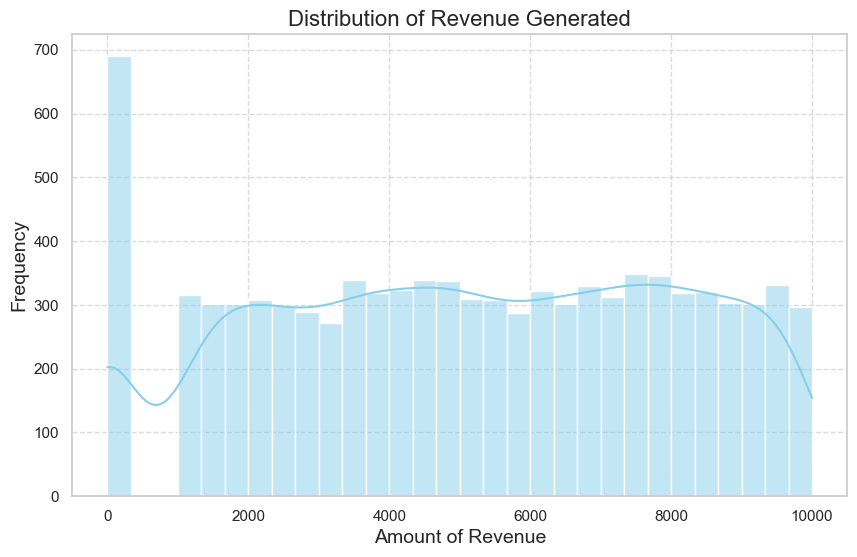

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['revenue_generated'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Revenue Generated', fontsize=16)
plt.xlabel('Amount of Revenue', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

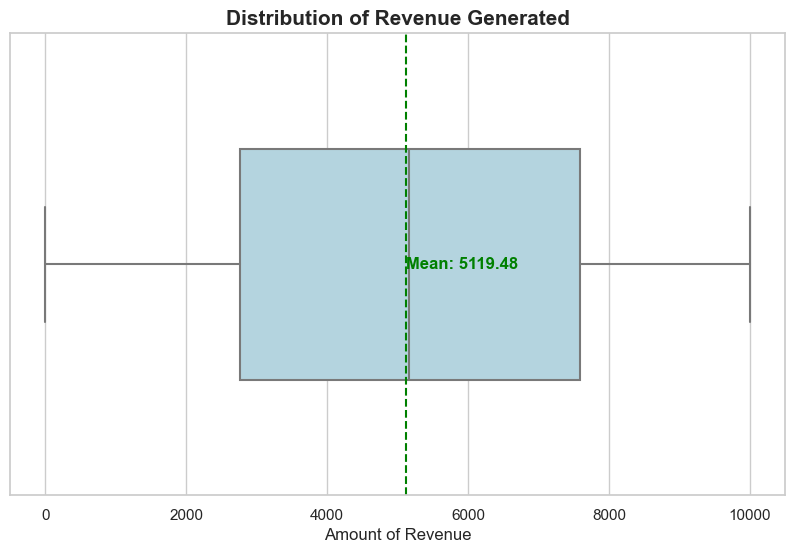

In [27]:
plt.figure(figsize=(10, 6))  
boxplot = sns.boxplot(x=supply_chain_eda_df['revenue_generated'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Revenue Generated', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Amount of Revenue', fontsize=12)
boxplot.set_ylabel('') 

mean_price = supply_chain_eda_df['revenue_generated'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Stock levels`

In [28]:
supply_chain_eda_df['stock_levels'].describe()

count    9170.000000
mean       50.154635
std        27.821614
min         1.000000
25%        27.000000
50%        50.000000
75%        74.000000
max        99.000000
Name: stock_levels, dtype: float64

- The average stock level is approximately 49.98 units.
- Stock levels show high variability with a standard deviation of 28.68 units.
- The minimum stock level recorded is 1 unit.
- 25% of the products have stock levels of 25 units or less.
- The median stock level is 51 units, meaning half of the products have stock levels less than this amount.
- 75% of the products have stock levels of 75 units or less.
- The maximum stock level recorded is 99 units.

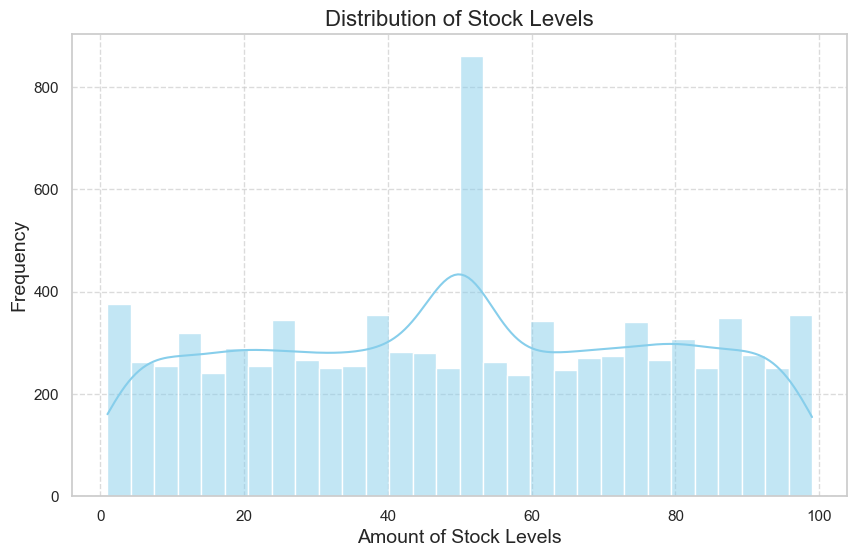

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['stock_levels'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Stock Levels', fontsize=16)
plt.xlabel('Amount of Stock Levels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

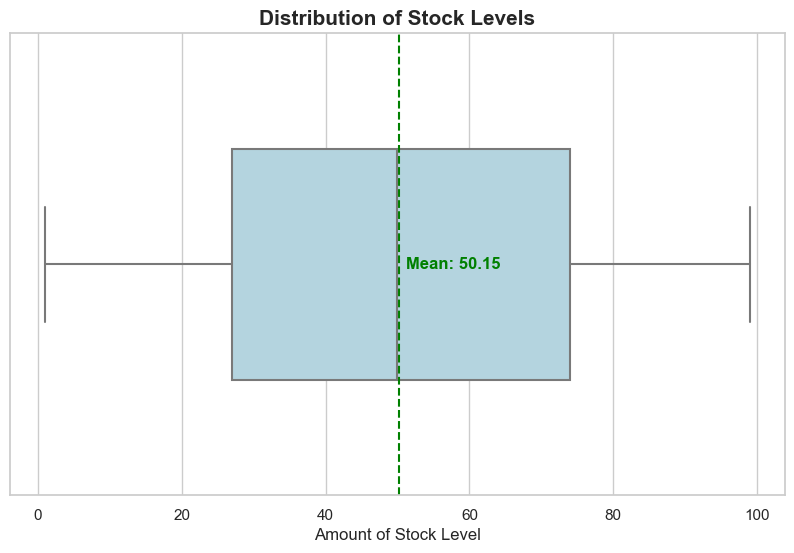

In [30]:
plt.figure(figsize=(10, 6))  
boxplot = sns.boxplot(x=supply_chain_eda_df['stock_levels'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Stock Levels', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Amount of Stock Level', fontsize=12)
boxplot.set_ylabel('')  

mean_price = supply_chain_eda_df['stock_levels'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Lead times`

In [31]:
supply_chain_eda_df['lead_times'].describe()

count    9170.000000
mean       14.700872
std         8.041001
min         1.000000
25%         8.000000
50%        15.000000
75%        21.000000
max        29.000000
Name: lead_times, dtype: float64

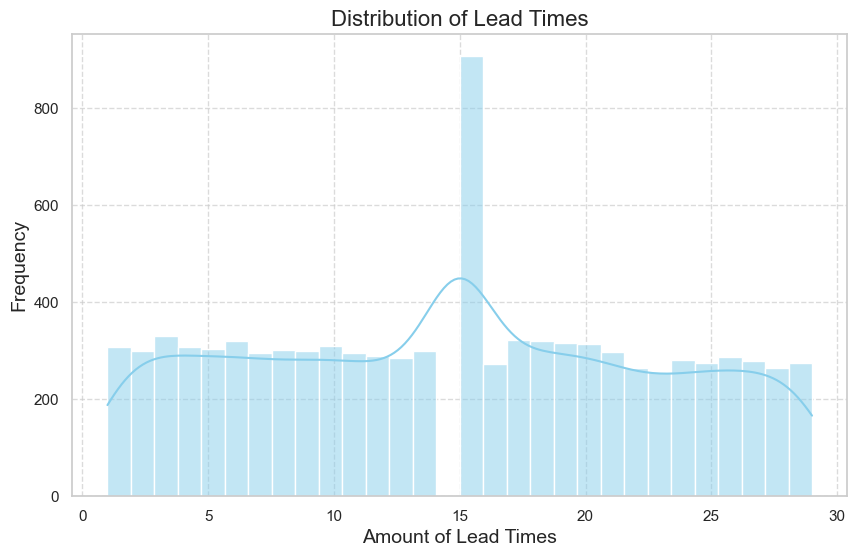

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['lead_times'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Lead Times', fontsize=16)
plt.xlabel('Amount of Lead Times', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

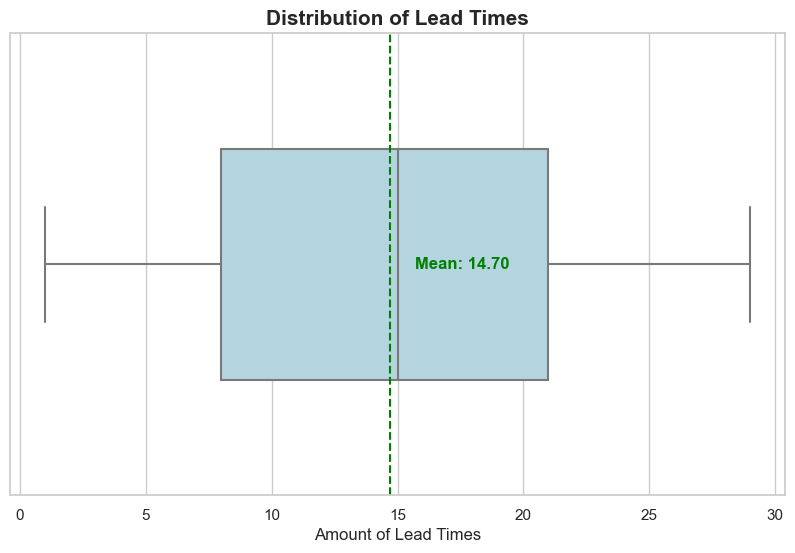

In [33]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['lead_times'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Lead Times', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Amount of Lead Times', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['lead_times'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Order quantities`

In [34]:
supply_chain_eda_df['order_quantities'].describe()

count    9170.000000
mean       50.197874
std        27.794887
min         1.000000
25%        27.000000
50%        50.500000
75%        74.000000
max        99.000000
Name: order_quantities, dtype: float64

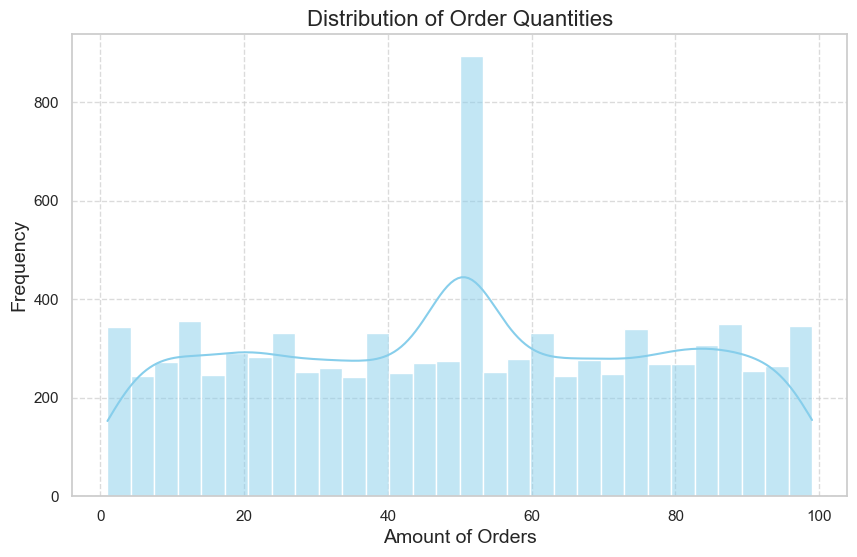

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['order_quantities'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Order Quantities', fontsize=16)
plt.xlabel('Amount of Orders', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

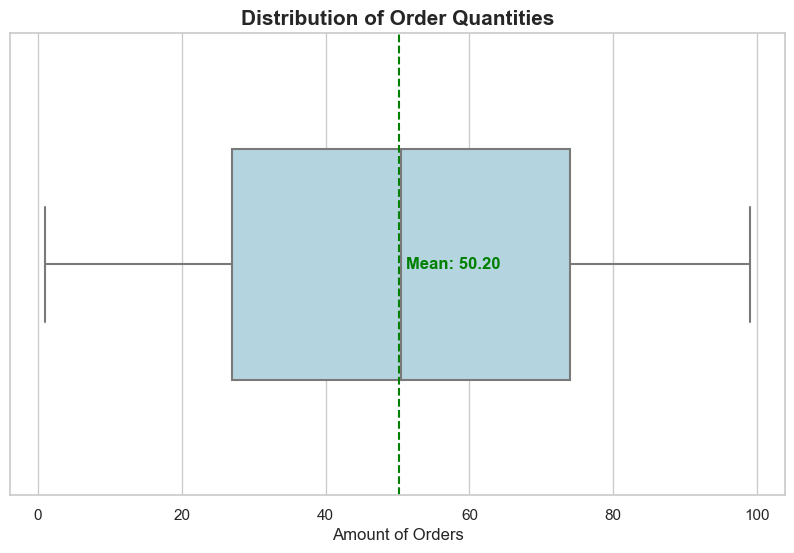

In [36]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['order_quantities'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Order Quantities', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Amount of Orders', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['order_quantities'].mean()
plt.axvline(mean_price, color='green', linestyle='--')  
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Shipping times`

In [37]:
supply_chain_eda_df['shipping_times'].describe()

count    9170.000000
mean        4.993784
std         2.468178
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max         9.000000
Name: shipping_times, dtype: float64

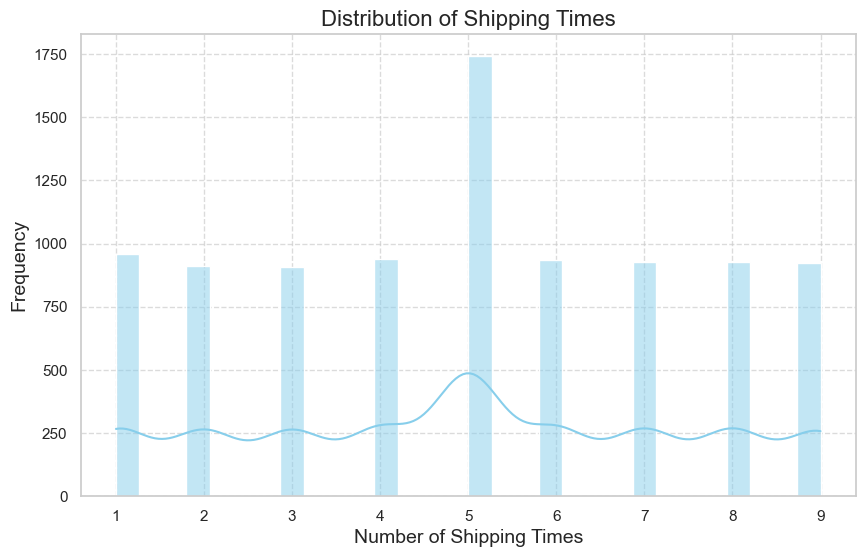

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['shipping_times'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Shipping Times', fontsize=16)
plt.xlabel('Number of Shipping Times', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

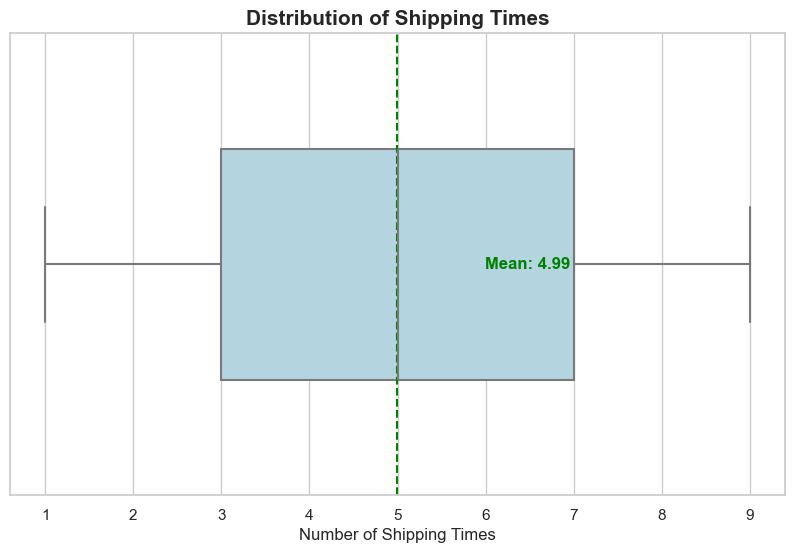

In [39]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['shipping_times'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Shipping Times', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Number of Shipping Times', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['shipping_times'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Production volumes`

In [40]:
supply_chain_eda_df['production_volumes'].describe()

count    9170.000000
mean      549.154635
std       251.737822
min       100.000000
25%       340.000000
50%       547.000000
75%       762.000000
max       999.000000
Name: production_volumes, dtype: float64

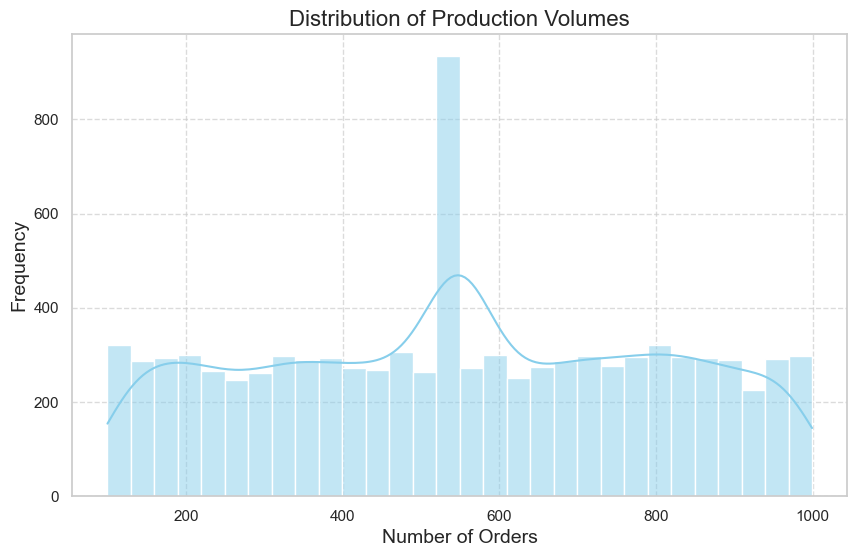

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['production_volumes'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Production Volumes', fontsize=16)
plt.xlabel('Number of Orders', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

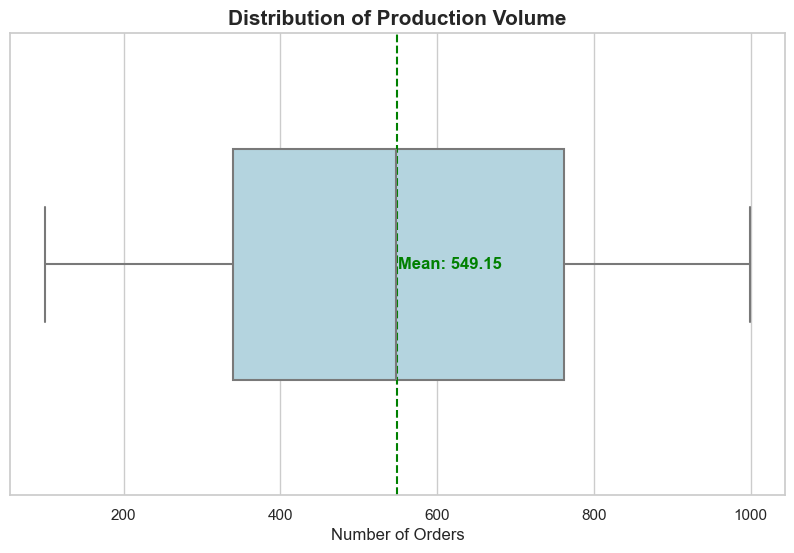

In [42]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['production_volumes'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Production Volume', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Number of Orders', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['production_volumes'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Manufacturing lead time`

In [43]:
supply_chain_eda_df['manufacturing_lead_time'].describe()

count    9170.000000
mean       14.932061
std         8.054704
min         1.000000
25%         8.000000
50%        15.000000
75%        22.000000
max        29.000000
Name: manufacturing_lead_time, dtype: float64

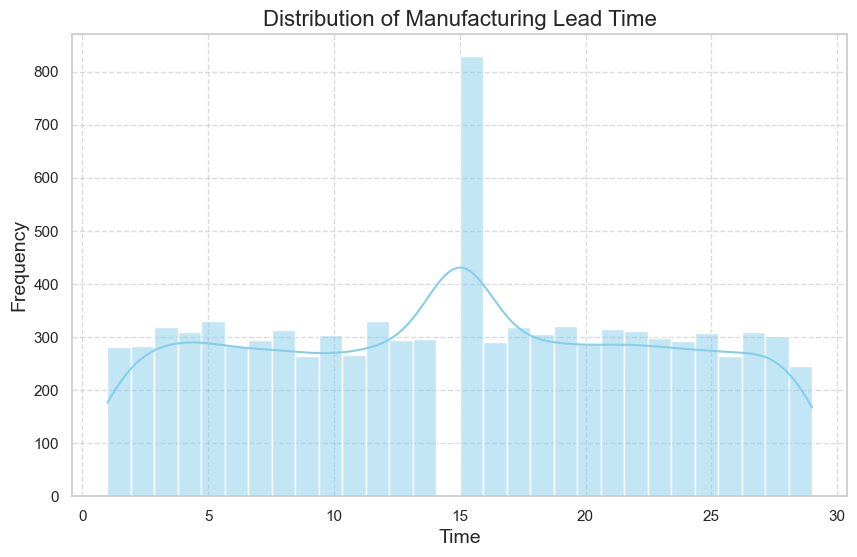

In [44]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['manufacturing_lead_time'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Manufacturing Lead Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

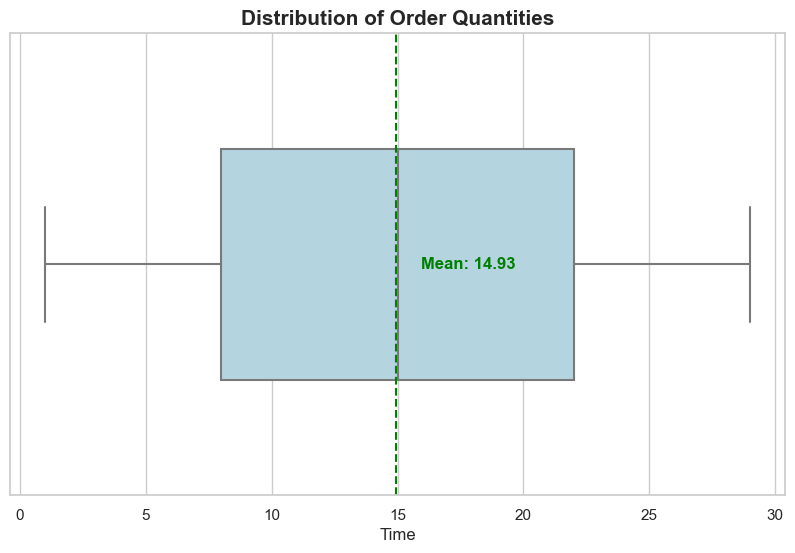

In [45]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['manufacturing_lead_time'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Order Quantities', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Time', fontsize=12)
boxplot.set_ylabel('') 

mean_price = supply_chain_eda_df['manufacturing_lead_time'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Manufacturing costs`

In [46]:
supply_chain_eda_df['manufacturing_costs'].describe()

count    9170.000000
mean       51.081433
std        28.580463
min         0.000000
25%        27.430000
50%        51.310000
75%        75.507500
max        99.990000
Name: manufacturing_costs, dtype: float64

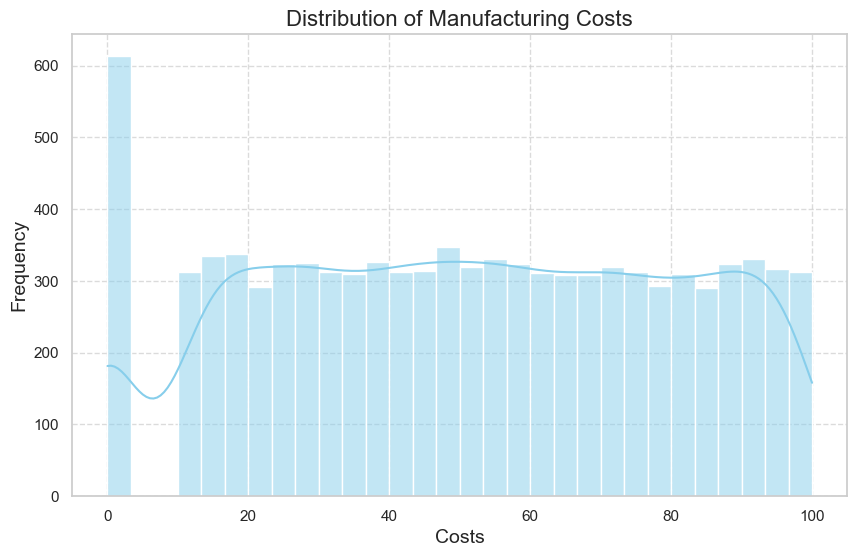

In [47]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['manufacturing_costs'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Manufacturing Costs', fontsize=16)
plt.xlabel('Costs', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

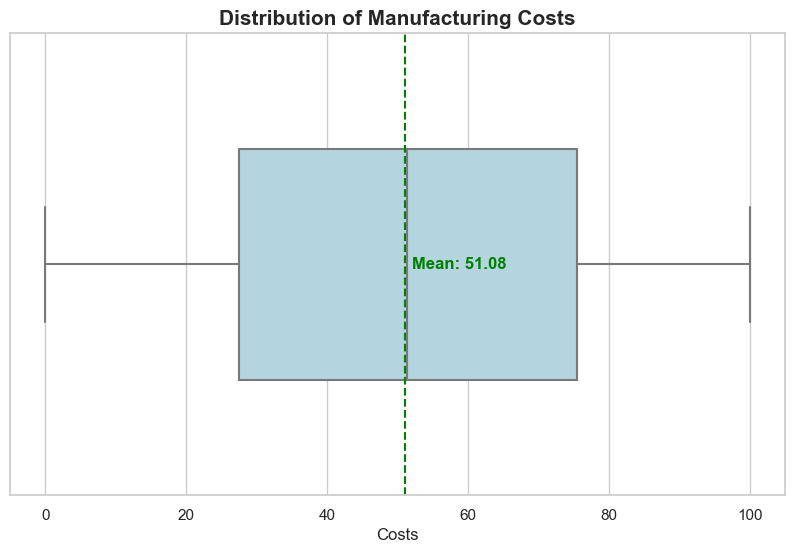

In [48]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['manufacturing_costs'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Manufacturing Costs', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Costs', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['manufacturing_costs'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Defect rates`

In [49]:
supply_chain_eda_df['defect_rates'].describe()

count    9170.000000
mean        2.506506
std         1.394080
min         0.000000
25%         1.340000
50%         2.500000
75%         3.670000
max         5.000000
Name: defect_rates, dtype: float64

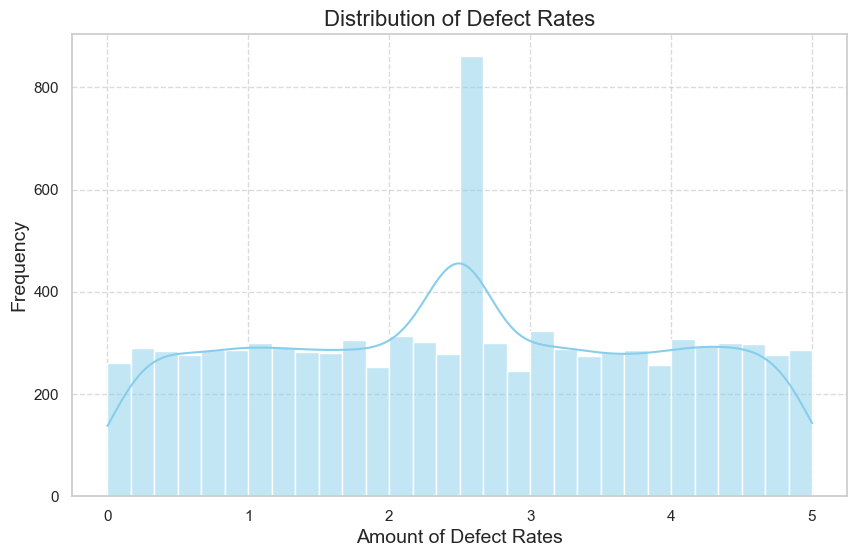

In [50]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['defect_rates'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Defect Rates', fontsize=16)
plt.xlabel('Amount of Defect Rates', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

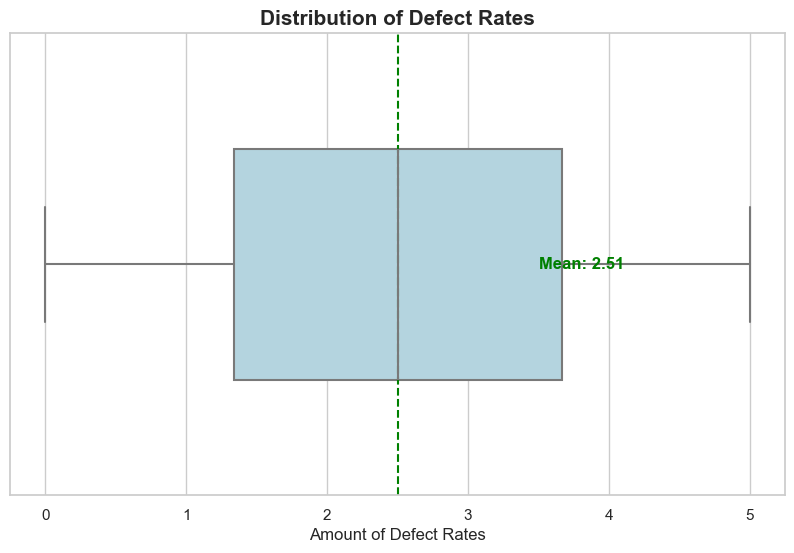

In [51]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['defect_rates'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Defect Rates', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Amount of Defect Rates', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['defect_rates'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Costs`

In [52]:
supply_chain_eda_df['costs'].describe()

count    9170.000000
mean      550.453944
std       250.896988
min       100.160000
25%       338.222500
50%       555.645000
75%       759.060000
max       999.630000
Name: costs, dtype: float64

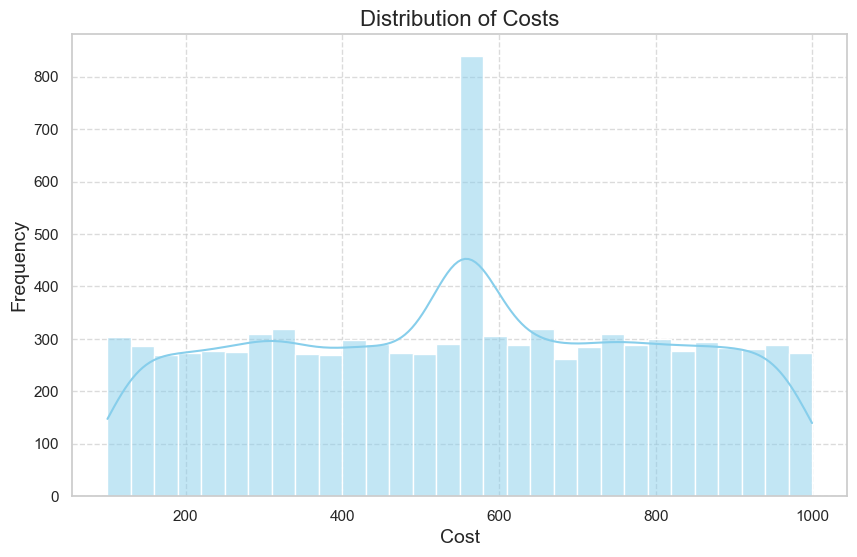

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['costs'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Costs', fontsize=16)
plt.xlabel('Cost', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

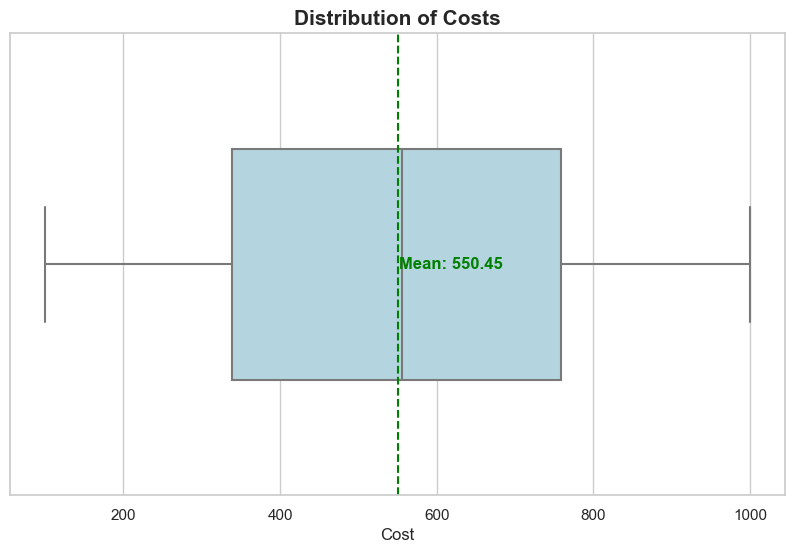

In [54]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['costs'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Costs', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Cost', fontsize=12)
boxplot.set_ylabel('') 

mean_price = supply_chain_eda_df['costs'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Estimated Price`

In [55]:
supply_chain_eda_df['estimated_price'].describe()

count     9170.000000
mean     50910.837514
std      27572.430764
min       1010.000000
25%      28212.500000
50%      51045.000000
75%      74240.000000
max      99990.000000
Name: estimated_price, dtype: float64

---

**Categorical columns:** [
    
    'Product type',
    'SKU',
    'Customer demographics',
    'Shipping carriers',
    'Supplier name',
    'Location',
    'Inspection results',
    'Transportation modes',
    'Routes'
]

---

`Product Type`

In [56]:
unique_values_counts = supply_chain_eda_df['product_type'].value_counts()
print(unique_values_counts)

product_type
skincare     3086
haircare     3045
cosmetics    3039
Name: count, dtype: int64


  Product Type  Frequency
0     skincare       3086
1     haircare       3045
2    cosmetics       3039


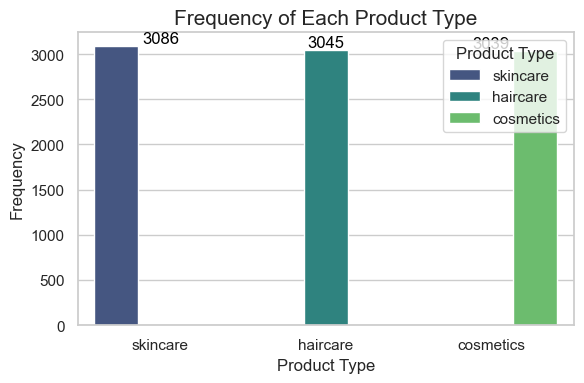

In [57]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Product Type', 'Frequency']

print(unique_values_counts_df)

plt.figure(figsize=(6, 4))
barplot = sns.barplot(x='Product Type', y='Frequency',hue='Product Type', data=unique_values_counts_df,palette='viridis')

barplot.set_title('Frequency of Each Product Type', fontsize=15)
barplot.set_xlabel('Product Type', fontsize=12)
barplot.set_ylabel('Frequency', fontsize=12)

for index, row in unique_values_counts_df.iterrows():
    barplot.text(row.name, row.Frequency, row.Frequency, color='black', ha="center", va="bottom")

plt.tight_layout()
plt.show()

---

`SKU`

In [58]:
unique_values_counts = supply_chain_eda_df['sku'].value_counts()
print(unique_values_counts)

sku
062000005          1
OBPGS              1
DOEXGPPII          1
DO2978-27          1
DOCONO             1
                  ..
C570162-21092/1    1
C570162-21092/2    1
C570162-21176/3    1
C570162-21176/4    1
CHNI013            1
Name: count, Length: 9170, dtype: int64


In [59]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['SKU', 'Frequency']

print(unique_values_counts_df)

                  SKU  Frequency
0           062000005          1
1               OBPGS          1
2           DOEXGPPII          1
3           DO2978-27          1
4              DOCONO          1
...               ...        ...
9165  C570162-21092/1          1
9166  C570162-21092/2          1
9167  C570162-21176/3          1
9168  C570162-21176/4          1
9169          CHNI013          1

[9170 rows x 2 columns]


---

`Customer Demographics`

In [60]:
unique_values_counts = supply_chain_eda_df['customer_demographics'].value_counts()
print(unique_values_counts)

customer_demographics
Unknown       2768
Male          2153
Female        2131
Non-binary    2118
Name: count, dtype: int64


In [61]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Customer Demographics', 'Frequency']

print(unique_values_counts_df)

  Customer Demographics  Frequency
0               Unknown       2768
1                  Male       2153
2                Female       2131
3            Non-binary       2118


---

`Shipping carriers`

In [62]:
unique_values_counts = supply_chain_eda_df['shipping_carriers'].value_counts()
print(unique_values_counts)

shipping_carriers
Carrier C    2873
Carrier A    2837
Carrier B    2786
Unknown       674
Name: count, dtype: int64


In [63]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Shipping carriers', 'Frequency']

print(unique_values_counts_df)

  Shipping carriers  Frequency
0         Carrier C       2873
1         Carrier A       2837
2         Carrier B       2786
3           Unknown        674


---

`Supplier name`

In [64]:
unique_values_counts = supply_chain_eda_df['supplier_name'].value_counts()
print(unique_values_counts)

supplier_name
Supplier 3    1690
Supplier 4    1689
Supplier 1    1685
Supplier 5    1655
Supplier 2    1600
Unknown        851
Name: count, dtype: int64


In [65]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Supplier Name', 'Frequency']

print(unique_values_counts_df)

  Supplier Name  Frequency
0    Supplier 3       1690
1    Supplier 4       1689
2    Supplier 1       1685
3    Supplier 5       1655
4    Supplier 2       1600
5       Unknown        851


---

`Location`

In [66]:
unique_values_counts = supply_chain_eda_df['location'].value_counts()
print(unique_values_counts)

location
Mumbai       1757
Chennai      1731
Kolkata      1719
Delhi        1687
Bangalore    1618
Unknown       658
Name: count, dtype: int64


In [67]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Location', 'Frequency']

print(unique_values_counts_df)

    Location  Frequency
0     Mumbai       1757
1    Chennai       1731
2    Kolkata       1719
3      Delhi       1687
4  Bangalore       1618
5    Unknown        658


---

`Inspection results`

In [68]:
unique_values_counts = supply_chain_eda_df['inspection_results'].value_counts()
print(unique_values_counts)

inspection_results
Pending    2937
Fail       2840
Pass       2814
Unknown     579
Name: count, dtype: int64


In [69]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Inspection Results', 'Frequency']

print(unique_values_counts_df)

  Inspection Results  Frequency
0            Pending       2937
1               Fail       2840
2               Pass       2814
3            Unknown        579


---

`Transportation modes`

In [70]:
unique_values_counts = supply_chain_eda_df['transportation_modes'].value_counts()
print(unique_values_counts)

transportation_modes
Sea        2136
Road       2091
Rail       2055
Air        2052
Unknown     836
Name: count, dtype: int64


In [71]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Transportation Modes', 'Frequency']

print(unique_values_counts_df)

  Transportation Modes  Frequency
0                  Sea       2136
1                 Road       2091
2                 Rail       2055
3                  Air       2052
4              Unknown        836


---

`Routes`

In [72]:
unique_values_counts = supply_chain_eda_df['routes'].value_counts()
print(unique_values_counts)

routes
Route_B    2847
Route_A    2846
Route_C    2723
Unknown     754
Name: count, dtype: int64


In [73]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Routes', 'Frequency']

print(unique_values_counts_df)

    Routes  Frequency
0  Route_B       2847
1  Route_A       2846
2  Route_C       2723
3  Unknown        754


---

### Multivariate Analysis

**Data Distributions**

In [74]:
numeric_features = supply_chain_eda_df.select_dtypes(include=['int64', 'float64'])

In [75]:
numeric_features.columns

Index(['estimated_price', 'availability', 'number_of_products_sold',
       'revenue_generated', 'stock_levels', 'lead_times', 'order_quantities',
       'shipping_times', 'shipping_costs', 'production_volumes',
       'manufacturing_lead_time', 'manufacturing_costs', 'defect_rates',
       'costs', 'demurrage'],
      dtype='object')

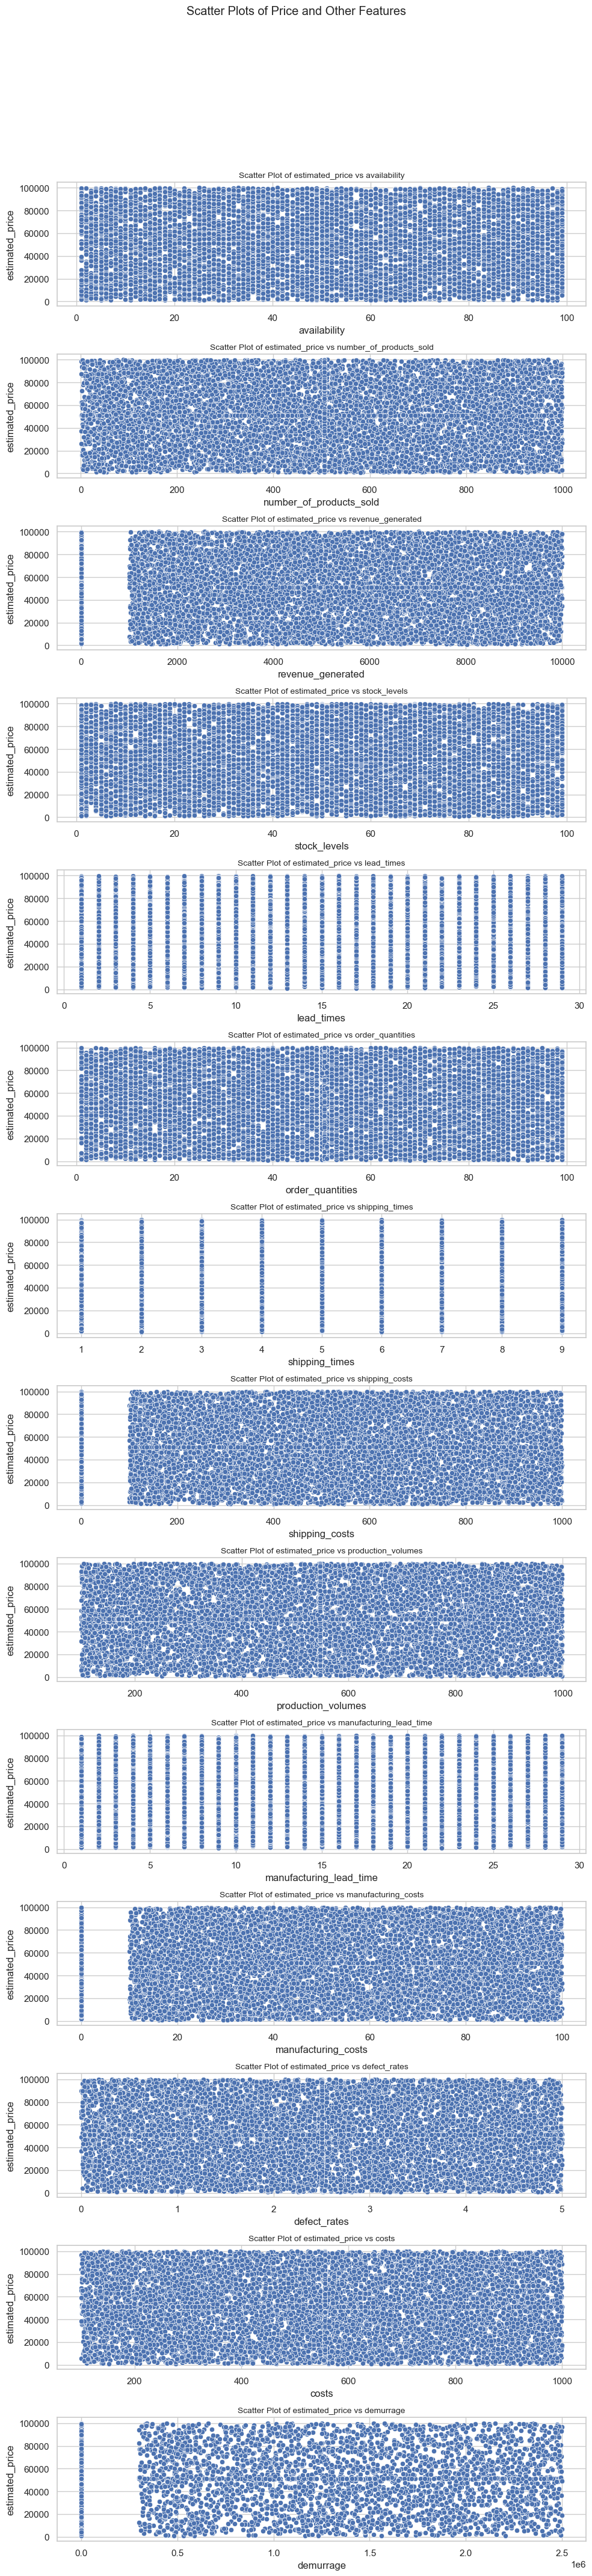

In [76]:
numeric_features = supply_chain_eda_df.select_dtypes(include=['int64', 'float64'])

target = 'estimated_price'
variables = numeric_features.columns.drop(target)

fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize=(10, len(variables) * 3))

for i, var in enumerate(variables):
    sns.scatterplot(x=numeric_features[var], y=numeric_features[target], ax=axes[i])
    axes[i].set_title(f'Scatter Plot of {target} vs {var}', fontsize=10)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel(target)

plt.tight_layout()
fig.suptitle('Scatter Plots of Price and Other Features', y=1.02)
plt.subplots_adjust(top=0.95)
plt.show()


---

**Correlation Matrix**

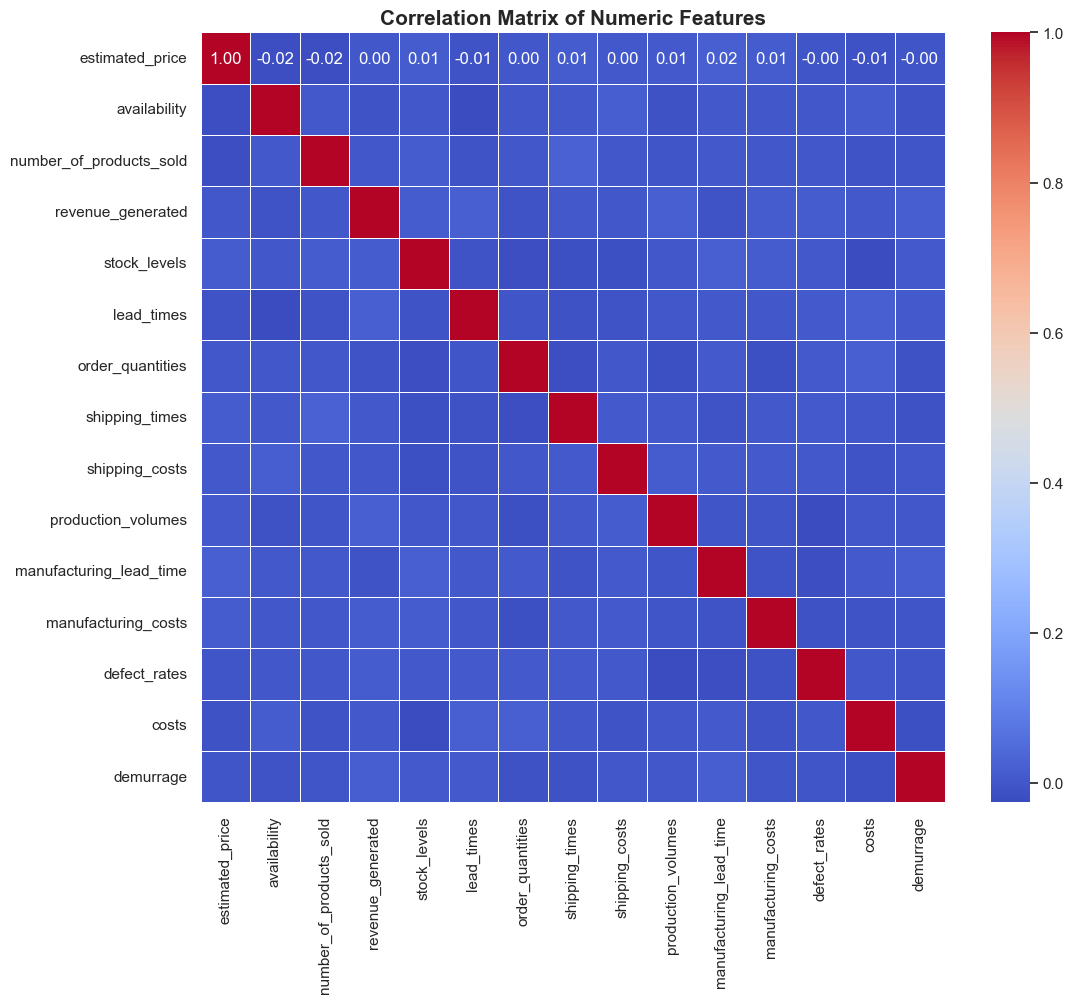

In [77]:
correlation_matrix = numeric_features.corr()

plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

heatmap.set_title('Correlation Matrix of Numeric Features', fontsize=15, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

- Price has a low correlation with all other variables, indicating that price changes do not significantly affect other features or vice versa. (No strong linear regression)
- Availability ,Lead times ,Shipping timesshows very low correlation with other features, suggesting that the availability of products is relatively independent of other features.
- The only notable correlation is between the number of products sold and revenue generated (r=0.33), which aligns with expectations as sales volume typically drives revenue.

---

**Multicollinearity**

In [78]:
numeric_features = supply_chain_eda_df.select_dtypes(include=['int64', 'float64'])

X = add_constant(numeric_features)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                    feature        VIF
0                     const  50.960903
1           estimated_price   1.001916
2              availability   1.001617
3   number_of_products_sold   1.001265
4         revenue_generated   1.001685
5              stock_levels   1.002440
6                lead_times   1.001870
7          order_quantities   1.001944
8            shipping_times   1.001852
9            shipping_costs   1.001019
10       production_volumes   1.001789
11  manufacturing_lead_time   1.001860
12      manufacturing_costs   1.001078
13             defect_rates   1.001494
14                    costs   1.002087
15                demurrage   1.001149


- All features have VIF values close to 1, indicating that there is very low multicollinearity among them.